Loading images and masks...
Loaded 5635 images and 5635 masks.
Loading test images...
Loaded 5508 test images.

Starting k-Fold Cross-Validation...

Processing Fold 1/5...
Epoch 1/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 1122s 4s/step - accuracy: 0.9827 - dice_coefficient: 0.8606 - loss: 0.0396 - val_accuracy: 1.0000 - val_dice_coefficient: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 1117s 4s/step - accuracy: 1.0000 - dice_coefficient: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_dice_coefficient: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 1111s 4s/step - accuracy: 1.0000 - dice_coefficient: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_dice_coefficient: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 1132s 4s/step - accuracy: 1.0000 - dice_coefficient: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_dice_coefficient: 1.0000

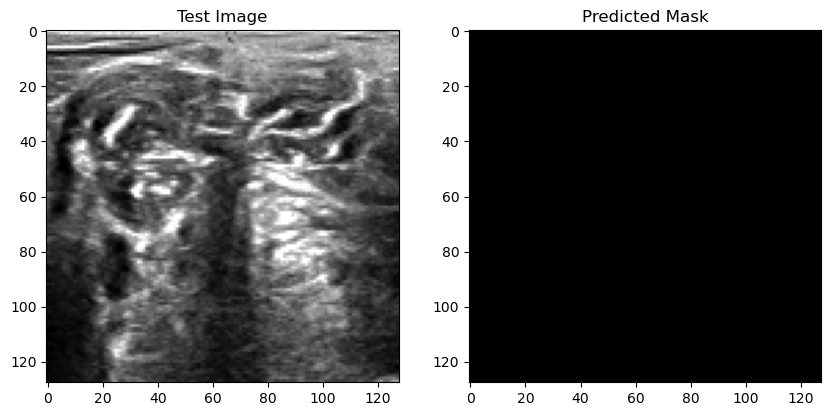

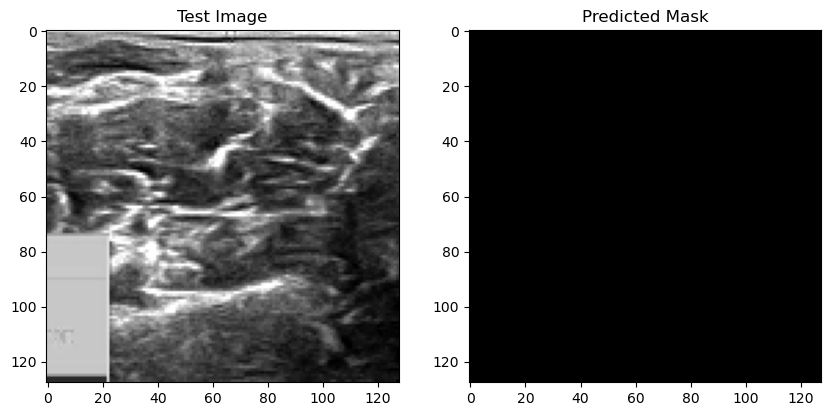

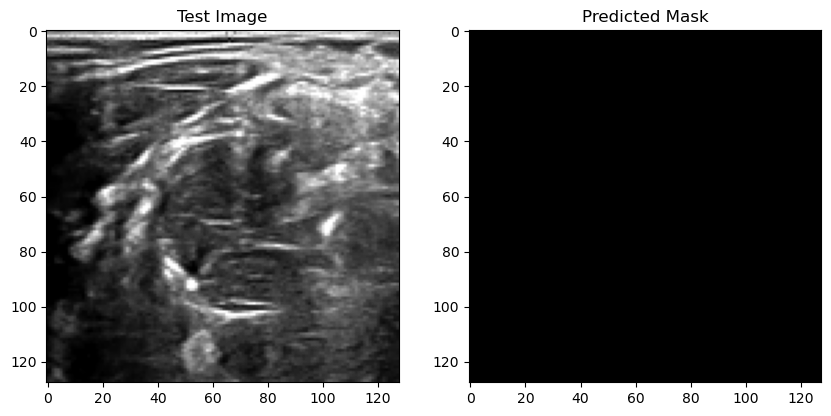

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import cv2

# Paths
train_images_path = "train/"
test_images_path = "test/"
train_masks_csv_path = "train_masks.csv"

# Image dimensions
IMG_HEIGHT, IMG_WIDTH = 128, 128

# Dice Coefficient function
def dice_coefficient(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1e-7) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1e-7)

# Load and preprocess training images and masks
def load_images_and_masks(image_dir, mask_csv):
    print("Loading images and masks...")
    images, masks = [], []
    masks_df = pd.read_csv(mask_csv).dropna(subset=["pixels"])
    masks_df = masks_df[masks_df["pixels"].str.contains(":")]

    for img_file in os.listdir(image_dir):
        if not img_file.endswith(".tif") or "_mask" in img_file:
            continue

        img_path = os.path.join(image_dir, img_file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        images.append(img)

        # Decode masks
        file_parts = img_file.split(".")[0].split("_")
        subject, img_num = file_parts[0], file_parts[1]
        mask_row = masks_df[(masks_df["subject"] == int(subject)) & (masks_df["img"] == int(img_num))]
        
        if not mask_row.empty:
            mask = np.zeros((IMG_HEIGHT * IMG_WIDTH,), dtype=np.uint8)
            for pair in mask_row["pixels"].iloc[0].split():
                start, length = map(int, pair.split(":"))
                mask[start:start + length] = 1
            mask = mask.reshape((IMG_HEIGHT, IMG_WIDTH))
        else:
            mask = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
        masks.append(mask)

    print(f"Loaded {len(images)} images and {len(masks)} masks.")
    return np.array(images), np.array(masks)

# Load test images
def load_test_images(test_dir):
    print("Loading test images...")
    images = []
    for img_file in os.listdir(test_dir):
        if not img_file.endswith(".tif"):
            continue
        img_path = os.path.join(test_dir, img_file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        images.append(img)
    print(f"Loaded {len(images)} test images.")
    return np.expand_dims(np.array(images) / 255.0, axis=-1)

# Create TensorFlow dataset
def create_dataset(images, masks, batch_size=16):
    dataset = tf.data.Dataset.from_tensor_slices((images, masks))
    dataset = dataset.shuffle(buffer_size=100).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# U-Net model
def build_unet(input_shape):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation="relu", padding="same")(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(64, (3, 3), activation="relu", padding="same")(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation="relu", padding="same")(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(128, (3, 3), activation="relu", padding="same")(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = Conv2D(256, (3, 3), activation="relu", padding="same")(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(256, (3, 3), activation="relu", padding="same")(c3)

    # Decoder
    u1 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(c3)
    u1 = concatenate([u1, c2])
    c4 = Conv2D(128, (3, 3), activation="relu", padding="same")(u1)
    c4 = Dropout(0.1)(c4)
    c4 = Conv2D(128, (3, 3), activation="relu", padding="same")(c4)

    u2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(c4)
    u2 = concatenate([u2, c1])
    c5 = Conv2D(64, (3, 3), activation="relu", padding="same")(u2)
    c5 = Dropout(0.1)(c5)
    c5 = Conv2D(64, (3, 3), activation="relu", padding="same")(c5)

    outputs = Conv2D(1, (1, 1), activation="sigmoid")(c5)

    return Model(inputs, outputs)

# Compile the model
def compile_model(input_shape):
    model = build_unet(input_shape)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", dice_coefficient])
    return model

# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3)

# Load training data
train_images, train_masks = load_images_and_masks(train_images_path, train_masks_csv_path)
train_images = np.expand_dims(train_images / 255.0, axis=-1)
train_masks = np.expand_dims((train_masks > 0).astype(np.float32), axis=-1)

# Load test images
test_images = load_test_images(test_images_path)

# Perform k-Fold Cross-Validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)
test_predictions = np.zeros(test_images.shape)  # To store predictions
fold_dice_scores, fold_accuracies = [], []

print("\nStarting k-Fold Cross-Validation...")
for fold, (train_index, val_index) in enumerate(kf.split(train_images), 1):
    print(f"\nProcessing Fold {fold}/{k}...")

    # Split data
    X_train, X_val = train_images[train_index], train_images[val_index]
    y_train, y_val = train_masks[train_index], train_masks[val_index]

    # Create datasets
    train_dataset = create_dataset(X_train, y_train)
    val_dataset = create_dataset(X_val, y_val)

    # Build and compile the model
    model = compile_model((IMG_HEIGHT, IMG_WIDTH, 1))

    # Train the model
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=10,
        callbacks=[early_stopping, lr_scheduler],
        verbose=1
    )

    # Evaluate on validation set
    val_predictions = model.predict(X_val, verbose=1)
    val_predictions = (val_predictions > 0.5).astype(np.float32)

    # Calculate metrics for this fold
    fold_dice = np.mean([dice_coefficient(y_true, y_pred).numpy() for y_true, y_pred in zip(y_val, val_predictions)])
    fold_accuracy = np.mean(np.equal(y_val, val_predictions).astype(np.float32))
    fold_dice_scores.append(fold_dice)
    fold_accuracies.append(fold_accuracy)

    print(f"Fold {fold} Dice Coefficient: {fold_dice:.4f}, Accuracy: {fold_accuracy:.4f}")

    # Predict test images and aggregate results
    test_predictions += model.predict(test_images, verbose=1) / k

# Threshold test predictions
test_predictions = (test_predictions > 0.5).astype(np.float32)

# Display Dice Coefficient and Accuracy for test data
if "test_masks" in locals():
    test_dice = np.mean([dice_coefficient(y_true, y_pred).numpy() for y_true, y_pred in zip(test_masks, test_predictions)])
    test_accuracy = np.mean(np.equal(test_masks, test_predictions).astype(np.float32))
    print(f"\nTest Data Dice Coefficient: {test_dice:.4f}, Accuracy: {test_accuracy:.4f}")

# Visualize test predictions
print("\nVisualizing test predictions...")
for i in range(3):  # Visualize 3 test predictions
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Test Image")
    plt.imshow(test_images[i].squeeze(), cmap="gray")
    plt.subplot(1, 2, 2)
    plt.title("Predicted Mask")
    plt.imshow(test_predictions[i].squeeze(), cmap="gray")
    plt.show()


Visualizing test predictions...


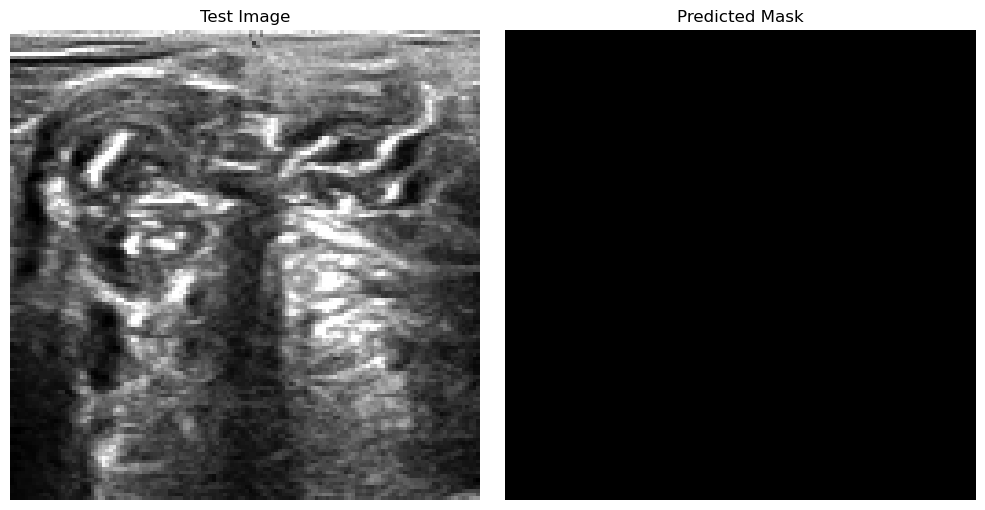

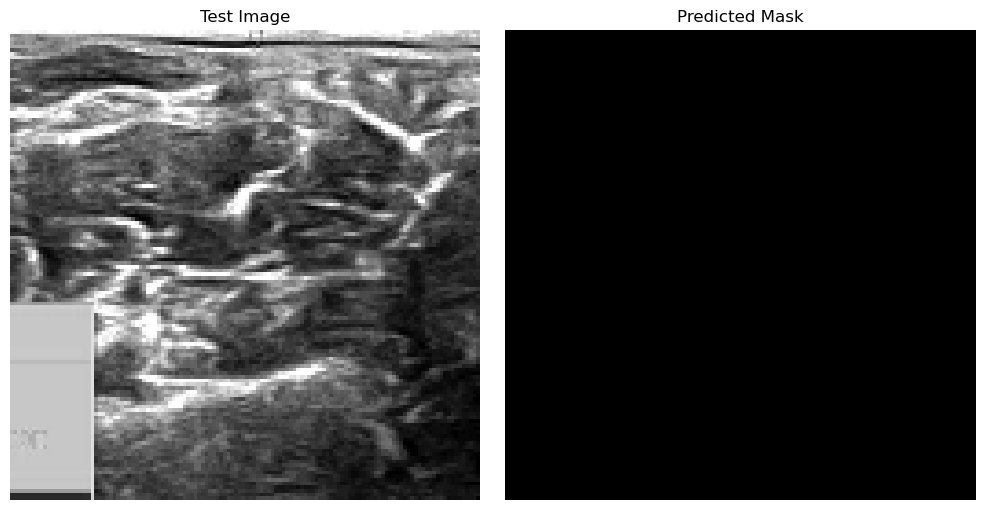

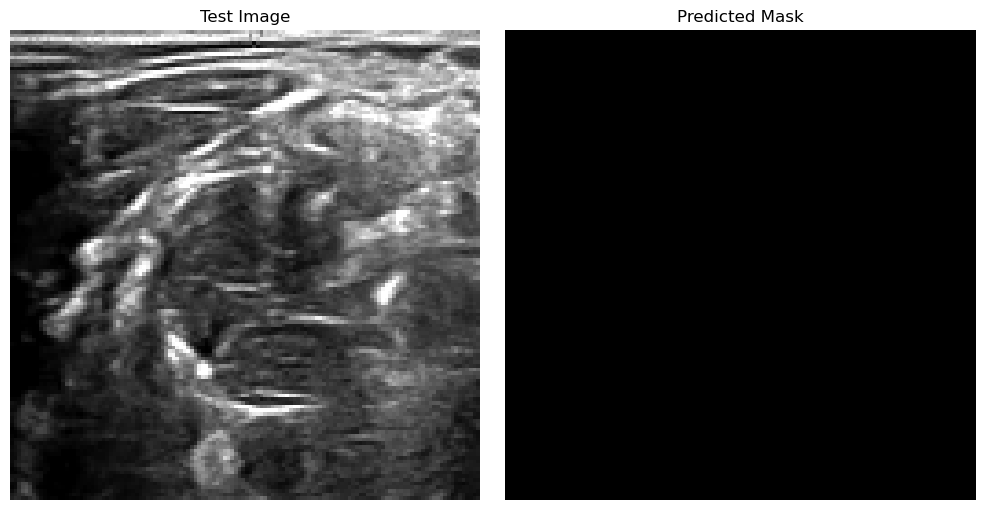

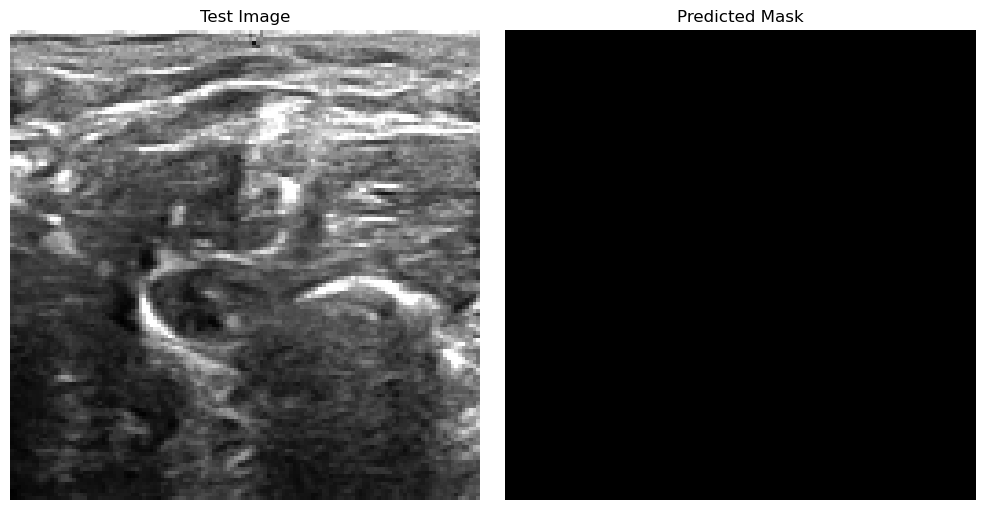

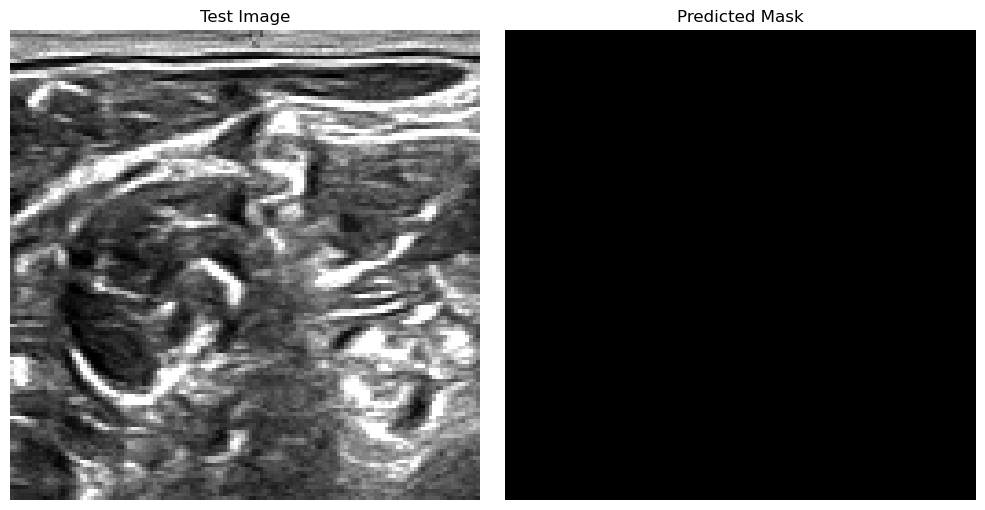

In [2]:
print("\nVisualizing test predictions...")

# Visualize the first few test images with predicted masks
for i in range(min(5, len(test_images))):  # Show up to 5 test samples
    plt.figure(figsize=(15, 5))

    # Show the test image
    plt.subplot(1, 3, 1)
    plt.title("Test Image")
    plt.imshow(test_images[i].squeeze(), cmap="gray")
    plt.axis("off")

    # Show the predicted mask
    plt.subplot(1, 3, 2)
    plt.title("Predicted Mask")
    plt.imshow(test_predictions[i].squeeze(), cmap="gray")
    plt.axis("off")

    # Show the ground truth mask, if available
    if "test_masks" in locals():
        plt.subplot(1, 3, 3)
        plt.title("Ground Truth Mask")
        plt.imshow(test_masks[i].squeeze(), cmap="gray")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


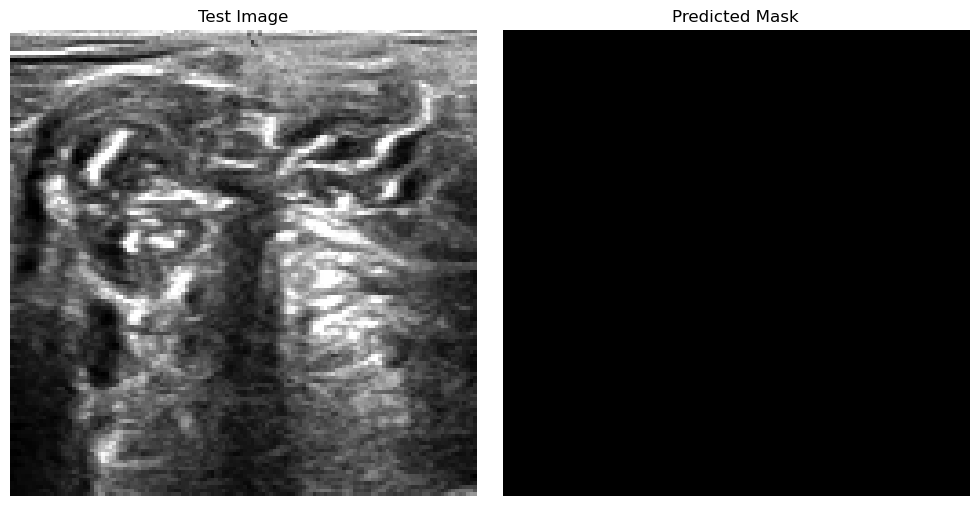

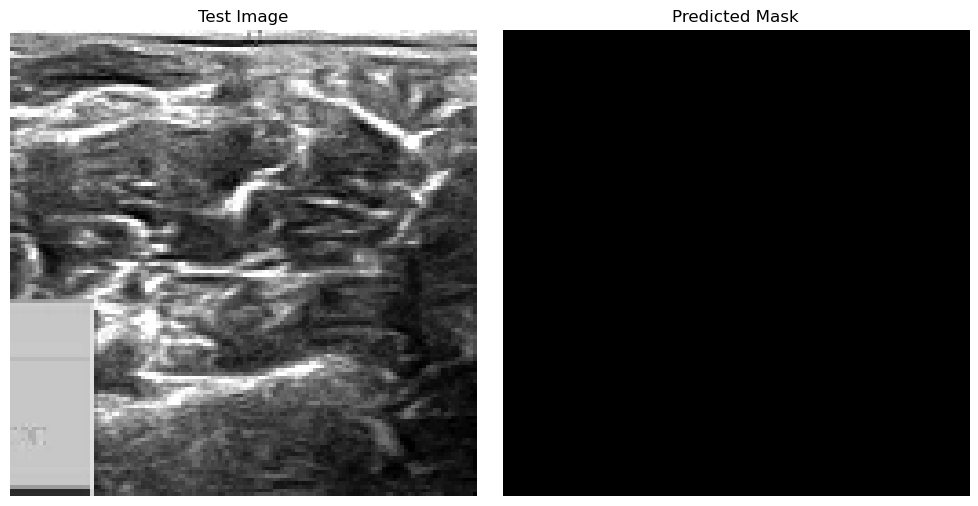

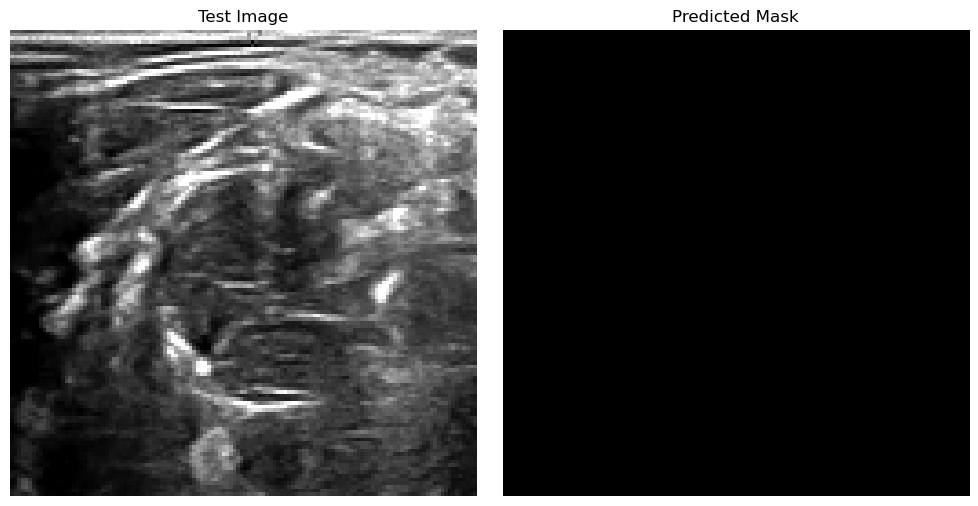

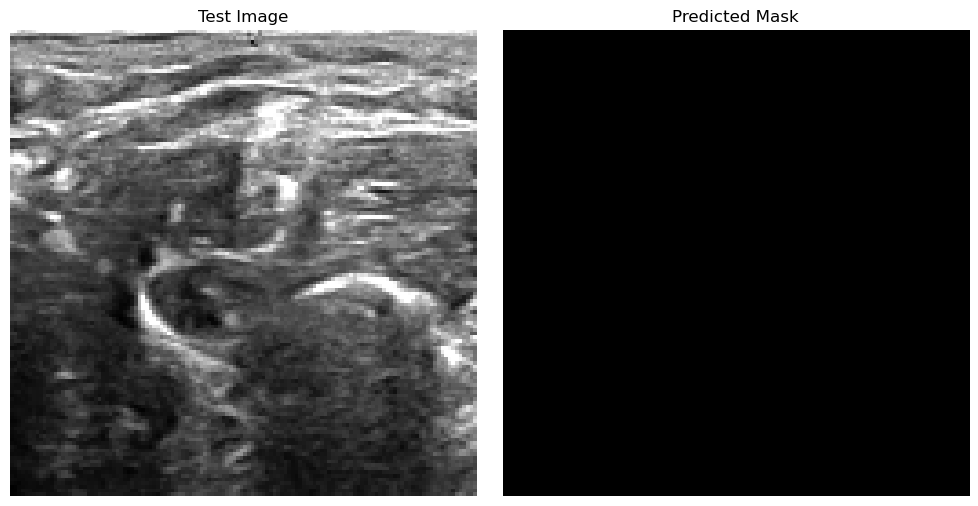

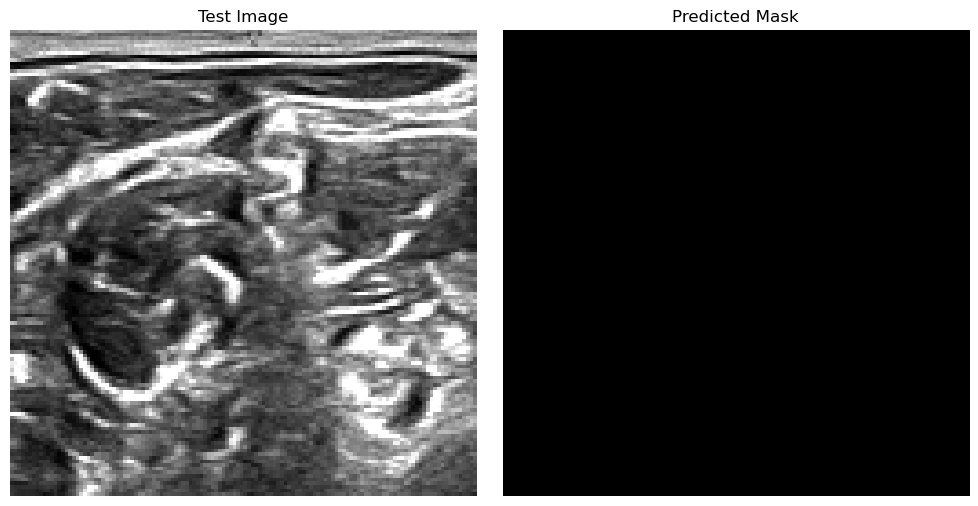

In [4]:
for i in range(min(5, len(test_images))):
    plt.figure(figsize=(10, 5))

    # Test image
    plt.subplot(1, 2, 1)
    plt.title("Test Image")
    plt.imshow(test_images[i].squeeze(), cmap="gray")
    plt.axis("off")

    # Predicted mask
    plt.subplot(1, 2, 2)
    plt.title("Predicted Mask")
    plt.imshow(test_predictions[i].squeeze(), cmap="gray")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


In [6]:
def generate_synthetic_masks(test_images):
    print("Generating synthetic ground truth masks...")
    synthetic_masks = []
    for image in test_images:
        # Apply thresholding (e.g., Otsu's method or fixed threshold)
        _, mask = cv2.threshold((image * 255).astype(np.uint8), 127, 1, cv2.THRESH_BINARY)
        synthetic_masks.append(mask)
    return np.array(synthetic_masks)

# Generate synthetic masks
test_masks = generate_synthetic_masks(test_images)
print(f"Generated synthetic masks with shape: {test_masks.shape}")


Generating synthetic ground truth masks...
Generated synthetic masks with shape: (5508, 128, 128)


Confusion Matrix:
 [[66007907        0]
 [24235165        0]]


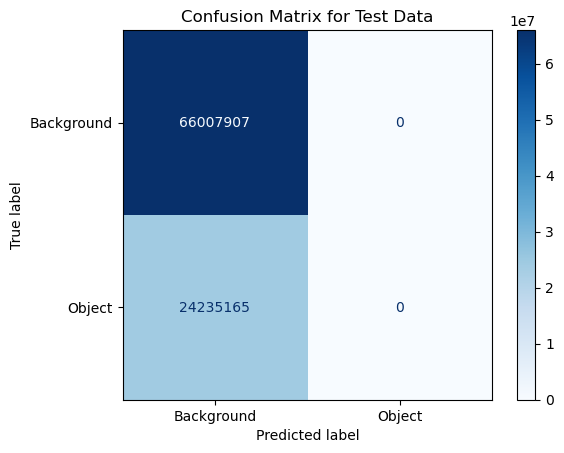

Accuracy: 0.7314
Precision: 0.0000
Recall: 0.0000
Dice Coefficient: 0.0000


In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Check if ground truth test masks are available
if "test_masks" in locals():
    # Flatten masks for pixel-wise comparison
    y_true = test_masks.flatten()  # Ground truth masks
    y_pred = test_predictions.flatten()  # Predicted masks

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    print("Confusion Matrix:\n", cm)

    # Display confusion matrix as a heatmap
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Background", "Object"])
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix for Test Data")
    plt.show()

    # Calculate evaluation metrics
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    dice = (2 * tp) / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Dice Coefficient: {dice:.4f}")
else:
    print("Ground truth test masks (test_masks) are not available. Cannot compute confusion matrix.")


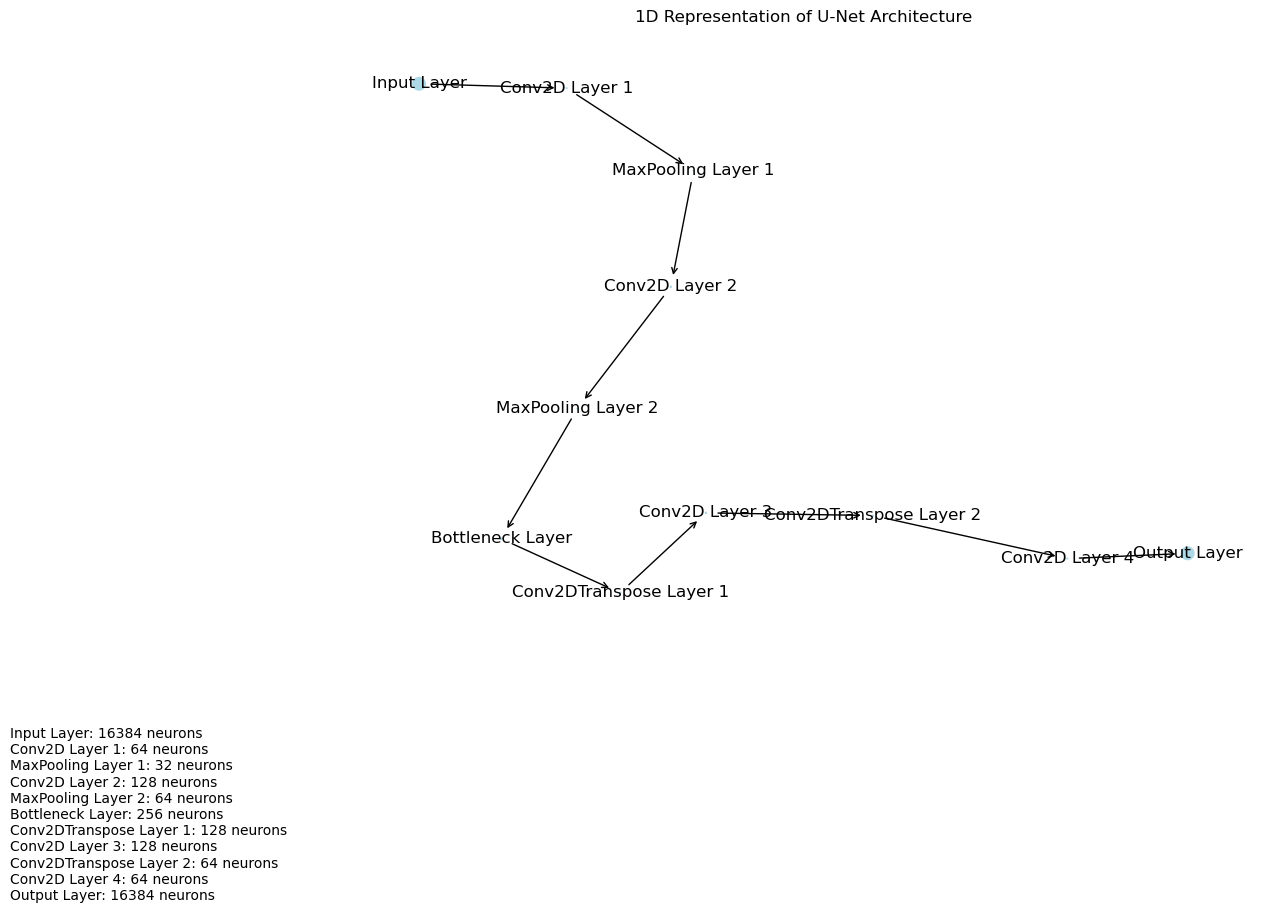

In [11]:
import matplotlib.pyplot as plt
import networkx as nx

# Initialize the graph
G = nx.DiGraph()

# Define the layers and number of neurons
layers = {
    "Input Layer": 128 * 128,  # Input image (128x128 pixels)
    "Conv2D Layer 1": 64,  # First Conv2D layer in encoder
    "MaxPooling Layer 1": 32,  # After downsampling
    "Conv2D Layer 2": 128,  # Second Conv2D layer in encoder
    "MaxPooling Layer 2": 64,  # After downsampling
    "Bottleneck Layer": 256,  # Bottleneck with Conv2D
    "Conv2DTranspose Layer 1": 128,  # Upsampling layer in decoder
    "Conv2D Layer 3": 128,  # First Conv2D in decoder
    "Conv2DTranspose Layer 2": 64,  # Upsampling layer in decoder
    "Conv2D Layer 4": 64,  # Second Conv2D in decoder
    "Output Layer": 128 * 128  # Binary mask output
}

# Add nodes and edges
previous = None
for layer in layers:
    G.add_node(layer, size=layers[layer])
    if previous:
        G.add_edge(previous, layer)
    previous = layer

# Draw the graph
fig, ax = plt.subplots(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)
sizes = [G.nodes[node]['size'] / 200 for node in G]  # Scale node sizes for visualization
nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color="lightblue", ax=ax)
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=10, ax=ax)
nx.draw_networkx_labels(G, pos, ax=ax)

# Add layer details below the graph
details = "\n".join([f"{layer}: {neurons} neurons" for layer, neurons in layers.items()])
plt.text(-1.5, -1.5, details, fontsize=10, ha="left", wrap=True)

plt.title("1D Representation of U-Net Architecture")
plt.axis('off')
plt.show()
